# Quickstart

<div style="display:inline-block;">
    <img src="https://raw.githubusercontent.com/heidelbergcement/hcrystalball/master/docs/_static/hcrystal_ball_logo_black.svg" width="150px">
</div>

We are glad this package caught your attention, so let's try to briefly showcase its power.

### Data
In this tutorial, we will use a historical Rossmann sales dataset that
we load via the `hcrystalball.utils.get_sales_data` function.

A description of the dataset and available columns is given in the docstring.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
from hcrystalball.utils import get_sales_data

df = get_sales_data(n_dates=100, 
                    n_assortments=2, 
                    n_states=2, 
                    n_stores=2)

In [3]:
df

,Store,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2,State,HolidayCode
Date,,,,,,,,,,
2015-04-23,817,17520,True,False,False,a,a,False,BE,DE-BE
2015-04-23,251,16573,True,False,False,a,c,False,NW,DE-NW
2015-04-23,335,11189,True,False,False,b,a,True,NW,DE-NW
2015-04-23,380,10761,True,False,False,a,a,True,NW,DE-NW
2015-04-23,788,15793,True,False,False,a,c,False,BE,DE-BE
...,...,...,...,...,...,...,...,...,...,...
2015-07-31,523,15349,True,True,True,c,c,False,BE,DE-BE
2015-07-31,513,19959,True,True,True,a,a,False,BE,DE-BE
2015-07-31,380,17133,True,True,True,a,a,True,NW,DE-NW


### Define search space
Next step is to define `ModelSelector` for which frequency the data will be resampled to, how many steps ahead the forecast should run, and optionally define column, which contains ISO code of country/region to take holiday information for given days

Once done, creating grid search with possible exogenous columns and extending it with custom models

In [4]:
from hcrystalball.model_selection import ModelSelector

ms = ModelSelector(horizon=10, 
                   frequency='D', 
                   country_code_column='HolidayCode',
                  )

ms.create_gridsearch(sklearn_models=True,
                    n_splits = 2,
                    between_split_lag=None,
                    sklearn_models_optimize_for_horizon=False,
                    autosarimax_models=False,
                    prophet_models=False,
                    tbats_models=False,
                    exp_smooth_models=False,
                    average_ensembles=False,
                    stacking_ensembles=False,                    
                    exog_cols=['Open','Promo','SchoolHoliday','Promo2'],
                    )

In [5]:
from hcrystalball.wrappers import get_sklearn_wrapper    
from sklearn.linear_model import LinearRegression

ms.add_model_to_gridsearch(get_sklearn_wrapper(LinearRegression))

### Run model selection
By default the run will partition data by `partition_columns` and do for loop over all partitions. 

If you have a problem, that make parallelization overhead worth trying, you can also use `parallel_columns` - subset of `partition_columns` over which the parallel run (using prefect) will be started.

If expecting the run to take long, it might be good to directly store results. Here `output_path` and `persist_` methods might come convenient

In [6]:
# from prefect.engine.executors import LocalDaskExecutor
ms.select_model(df=df,
                target_col_name='Sales',
                partition_columns=['Assortment', 'State','Store'],
#                 parallel_over_columns=['Assortment'],
#                 persist_model_selector_results=False,
#                 output_path='my_results',
#                 executor = LocalDaskExecutor(),                
               )

### Look at the results
Naturaly we are interested in which models were chosen, so that we can strip our parameter grid from the ones, which were failing and extend with more sophisticated models from most selected classes

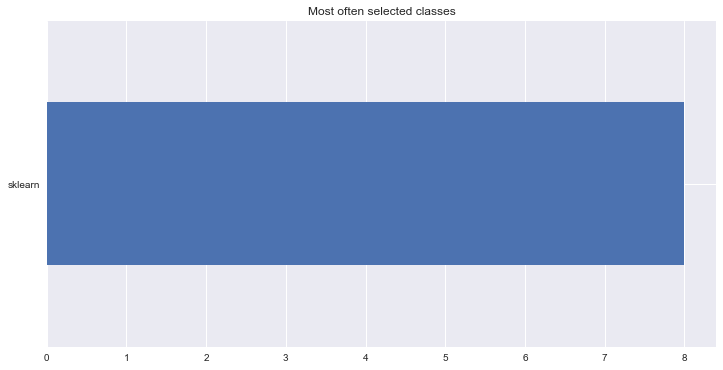

In [7]:
ms.plot_best_wrapper_classes();

There also exists convenient method to plot the results over all (or subset of) the data partitions to see how well our model fitted the data during cross validation

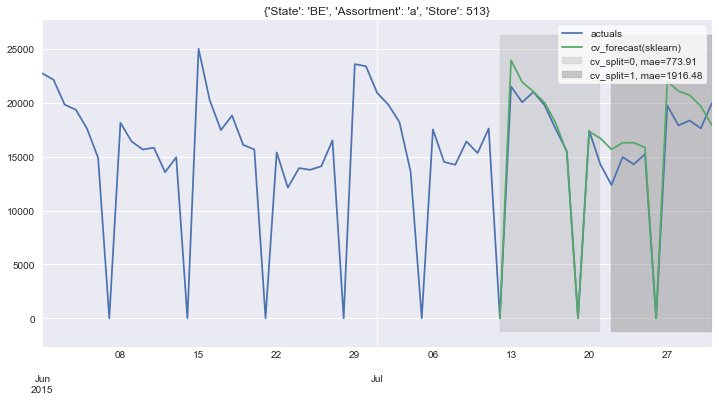

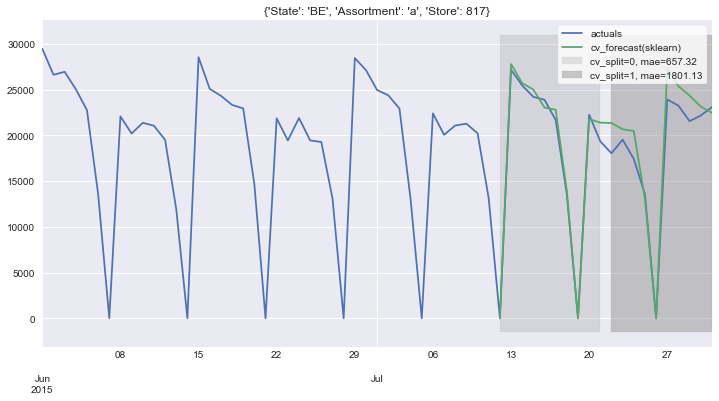

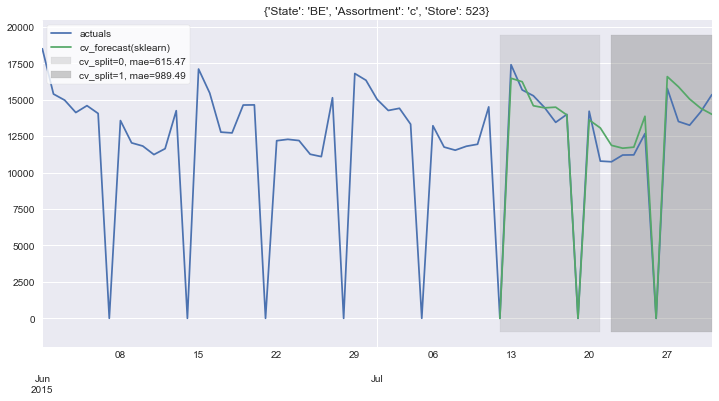

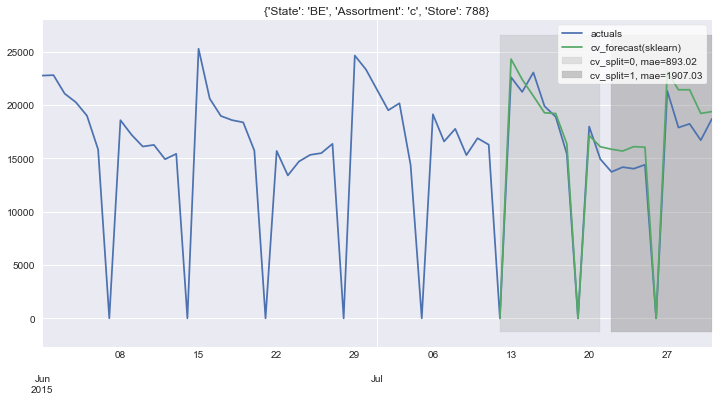

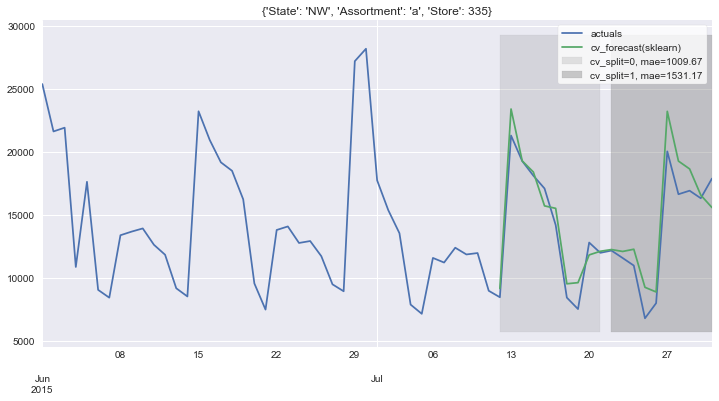

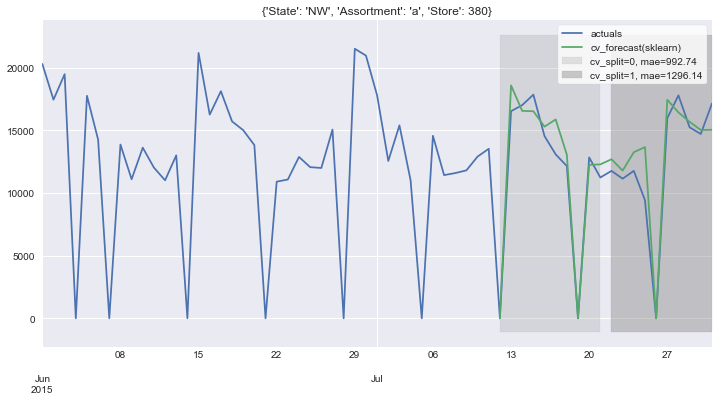

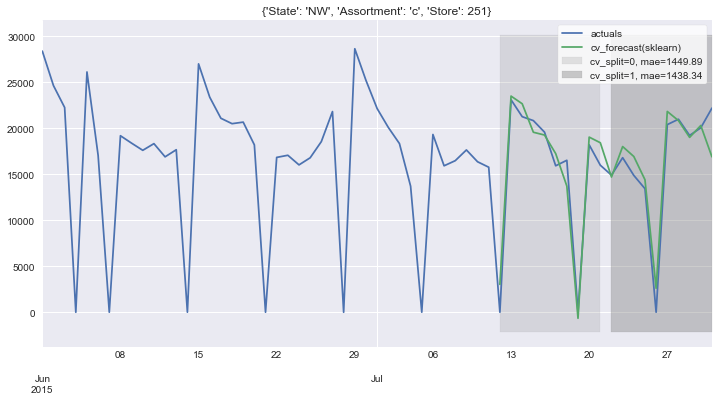

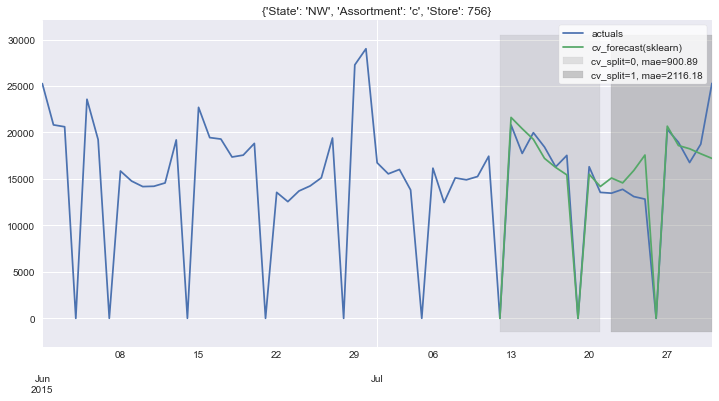

In [8]:
ms.plot_results(plot_from='2015-06-01');

### Accessing 1 Time-Series
To get to more information, it is advisable to go from all partitions level (`ModelSelector`) to single partition level (`ModelSelectorResult`).

`ModelSelector` stores results as a list of `ModelSelectorResult` objects in `self.results`. Here we provide rich `__repr__` that hints on what information are available. 

Another way to get the ModelSelectorResult is to use `ModelSelector.get_result_for_partition` that ensures the same results also when loading the stored results. Here the list access method fails (`ModelSelector.results[0]`), because each ModelSelectorResults is stored with `partition_hash` name and later load ingests these files in alphabetical order.

Accessing **training data** to see what is behind the model, cv_results to check the **fitting time** or how big margin my best model had over the second best one or access **model definition** and explore its **parameters** are all handy things that we found useful

In [9]:
ms.results[0]

ModelSelectorResult
-------------------
  best_model_name: sklearn
  frequency: D
  horizon: 10

  country_code_column: HolidayCode

  partition: {'State': 'BE', 'Assortment': 'a', 'Store': 513}
  partition_hash: 35869f6c9d41e4501656c91df37f1302

  df_plot: DataFrame (100, 6) suited for plotting cv results with .plot()
  X_train: DataFrame (100, 6) with training feature values
  y_train: DataFrame (100,) with training target values
  cv_results: DataFrame (19, 16) with gridsearch cv info
  best_model_cv_results: Series with gridsearch cv info
  cv_data: DataFrame (20, 21) with models predictions, split and true target values
  best_model_cv_data: DataFrame (20, 3) with model predictions, split and true target values

  model_reprs: Dict of model_hash and model_reprs
  best_model_hash: f8333d0b2a0f91e80ed46f76565b0b52
  best_model: Pipeline(memory=None,
         steps=[('exog_passthrough',
                 TSColumnTransformer(n_jobs=None, remainder='drop',
                              

In [10]:
res = ms.get_result_for_partition(partition=ms.results[0].partition)

#### Plotting results and errors for 1 time series
On this level we can also access the forecast plots - one that we already know with cv_forecasts and one that gives us only errors

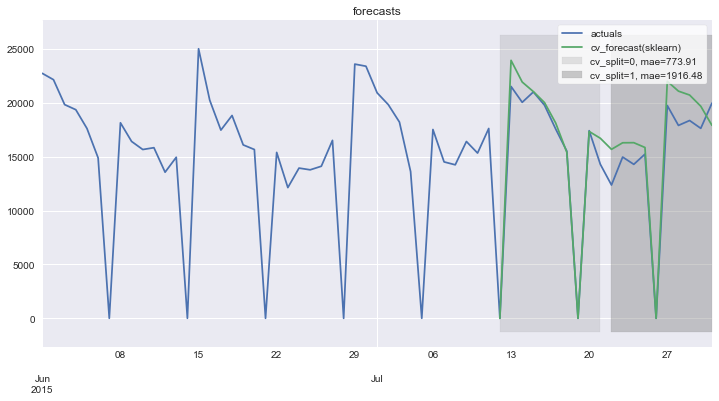

In [11]:
res.plot_result(plot_from = '2015-06-01', title='forecasts');

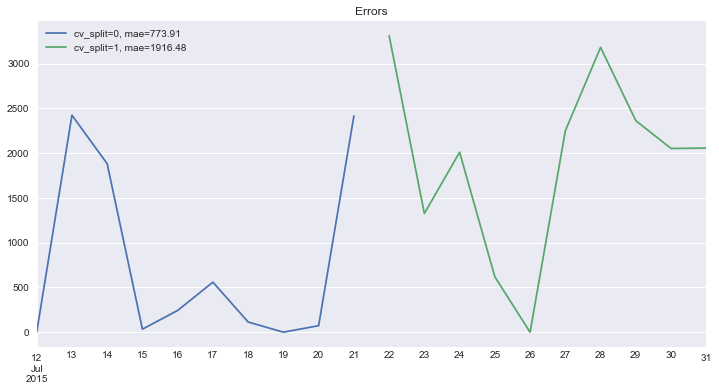

In [12]:
res.plot_error(title='Errors');

### Persist and load
To enable later usage of our found results, there are plenty of methods that can help storing and loading the results of model selection in a uniform way.

Some methods and functions persits/load the whole objects (`load_model_selector`, `load_model_selector_result`), while some provide direct access to the part we might only care if we run in production and have space limitations (`load_best_model`, `load_partition`, ...) 

In [13]:
from hcrystalball.model_selection import load_model_selector
from hcrystalball.model_selection import load_model_selector_result
from hcrystalball.model_selection import load_best_model

res.persist(path='tmp')
res = load_model_selector_result(path='tmp',partition_label=ms.results[0].partition) 

ms.persist_results(folder_path='tmp/results')
ms = load_model_selector(folder_path='tmp/results')

In [14]:
ms = load_model_selector(folder_path='tmp/results')

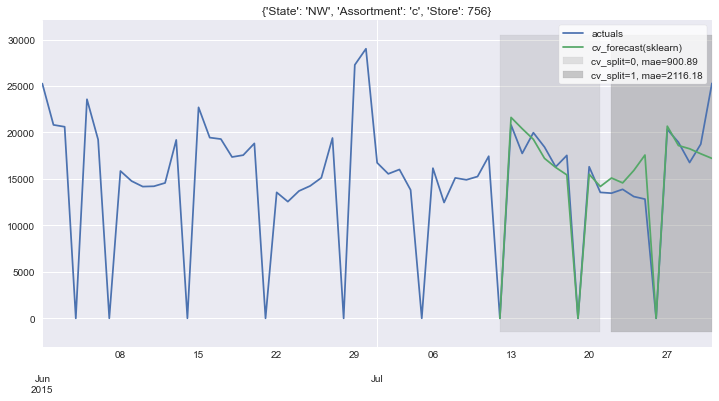

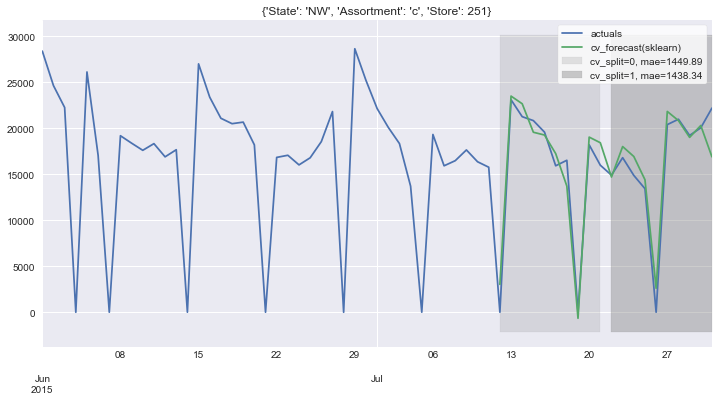

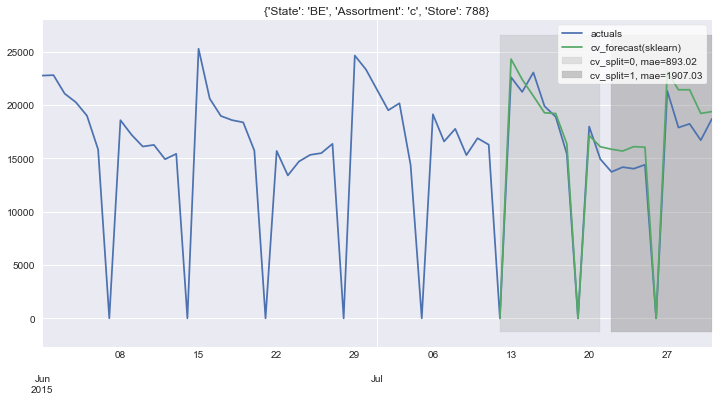

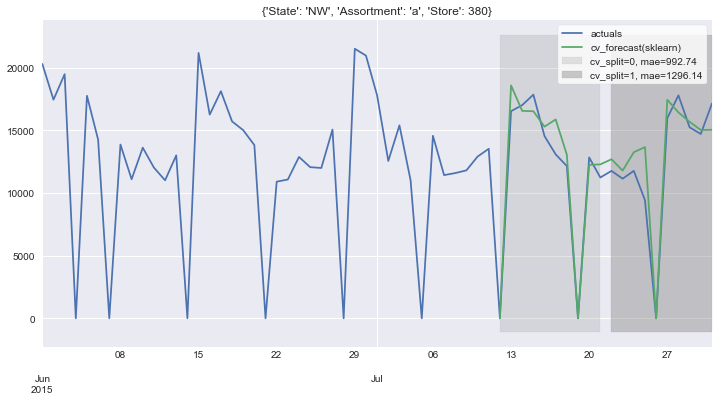

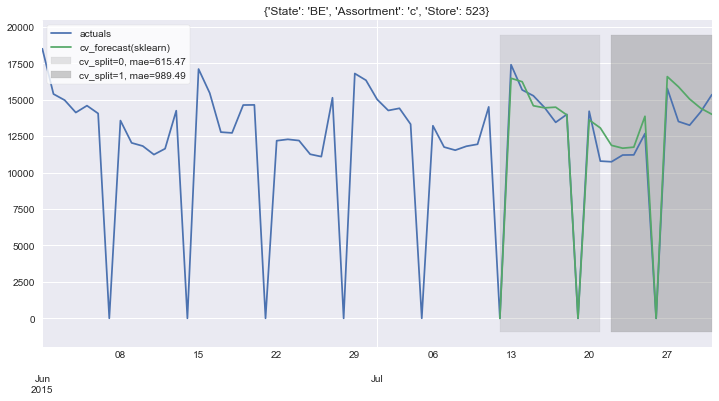

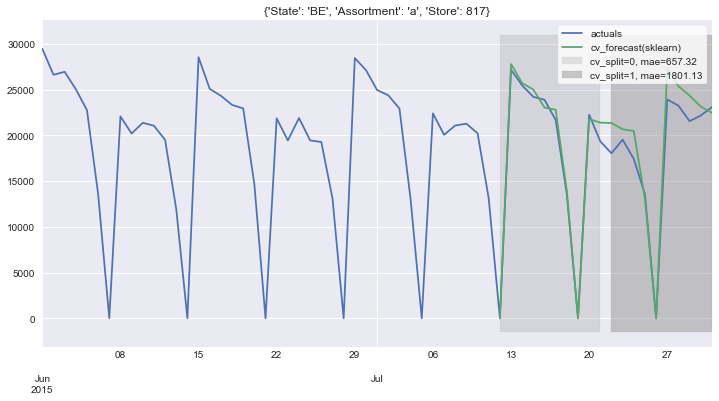

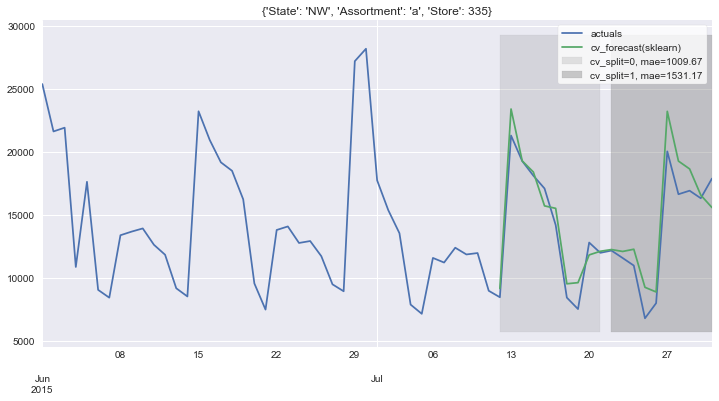

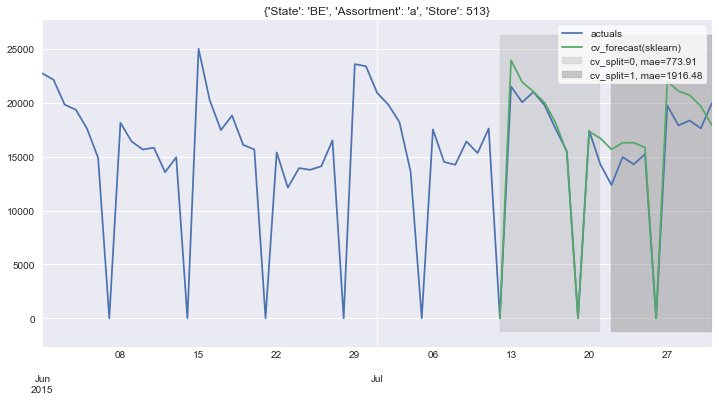

In [15]:
ms.plot_results(plot_from='2015-06-01');

In [16]:
# cleanup
import shutil
try:
    shutil.rmtree('tmp')
except:
    pass